# Machine Learning Project: French Grand Debat

### Project Introduction :

First, we would like to choose a problematic according to the data we collected. The aim of this project could be to answer the following questions:

* What are the 5 most important ideas on each theme?
* Can we build different profiles of people with their ideas on the 4 themes?
* Can we predict themes about which people could be interested in if those people answered questions only about 3 on 4 themes? 
 
#### Doability :

We are going to import the data, then check if the ids of people who submitted ideas on different themes are the same. If not, we won't be able to answer the second question.


In [ ]:
# librairies imported
import src.utils as ut
import numpy as np
import pandas as pd
import string
from src.kmeans_embeddings import FeaturesExtractor
from sklearn.cluster import KMeans
from src.utils import (read_data, get_open_reponses, get_ids_open_reponses)
from sklearn.mixture import GaussianMixture
import multiprocessing

#### Data extraction

In [ ]:
df_fiscalite = ut.read_data('data/LA_FISCALITE_ET_LES_DEPENSES_PUBLIQUES.json')
df_democratie = ut.read_data('data/DEMOCRATIE_ET_CITOYENNETE.json')
df_ecologie = ut.read_data('data/LA_TRANSITION_ECOLOGIQUE.json')
df_organisation = ut.read_data('data/ORGANISATION_DE_LETAT_ET_DES_SERVICES_PUBLICS.json')

dfs = np.array([["fiscalite", df_fiscalite], ["democratie", df_democratie], ["ecologie", df_ecologie], ["organisation", df_organisation]])

# open responses
df_resp_fis = get_open_reponses(df_fiscalite)
df_resp_dem = get_open_reponses(df_democratie)
df_resp_eco = get_open_reponses(df_ecologie)
df_resp_org = get_open_reponses(df_organisation)

dfs_responses = np.array([["responses fiscalite", df_resp_fis], ["responses democratie", df_resp_dem], ["responses ecologie", df_resp_eco], ["responses organisation", df_resp_org]])

In [ ]:
np.random.seed(1)
for i in np.random.randint(len(df_fiscalite), size=5):
    auth = df_fiscalite.loc[i, 'authorId']
    print("Author ID : " + auth)

    dfs = np.array([["fiscalite", df_fiscalite], ["democratie", df_democratie], ["ecologie", df_ecologie], ["organisation", df_organisation]])
    for df in dfs:
        code = df[1].loc[df[1]['authorId'] == auth, 'authorZipCode']
        if(len(code) > 0):
            code = code.values[0]
            print("* In " + df[0] + " survey, author has zip code : " + str(code))
        else:
            print("* In " + df[0] + " survey, author has not answered...")
    print("\n############################\n")

**From the previous lines, we can see that the `authorId` is likely to be an unique id whaterver the dataframe (zip code is the same).**

### How many people answered several themes ?

In order to build type-profiles, we need a large number of people who answered questions on several themes. That is what we will try to find with the following code.

**Be careful, this cell takes a lot of time to run !**

source file : `create_author_tabs.py`

In [ ]:
# allAuthIds is the sets of all the authorIds
allAuthIds = []
for i in range(4):
    allAuthIds.extend(set(dfs_responses[i,1]['authorId'].values))
allAuthIds = set(allAuthIds)

# all_auth_id_array is the sorted array of all the authorIds
all_auth_id_array = np.sort(np.array(list(allAuthIds)))

# auth_answers_count[i,j] is 1 if all_auth_id_array[i] has answered survey dfs[j]
auth_answers_count = np.zeros((len(allAuthIds), 4), dtype=int)
for j in range(4):
    for i in range(len(all_auth_id_array)):
        auth = all_auth_id_array[i]
        line = dfs_responses[j,1].loc[dfs_responses[j,1]['authorId'] == auth]
        if(len(line) > 0):
            auth_answers_count[i,j] = auth_answers_count[i,j] + 1

            
# This cell aims to save the auth_answers_count array in auth_answers_count.csv
np.savetxt("auth_answers_count.csv", auth_answers_count, fmt='%1u', delimiter=",")

# list of the authors that answered the four themes
four_surveys_taken_auth_ids = [all_auth_id_array[i] for i in range(len(all_auth_id_array)) if number_of_survey_taken[i] == 4]

np.savetxt("four_surveys_taken_auth_ids.csv", four_surveys_taken_auth_ids, delimiter=",")

**You can run this cell instead to load auth_answers_count from csv :**

In [ ]:
# Read auth_answers_count from auth_answers_count.csv
auth_answers_count = np.loadtxt('auth_answers_count.csv', dtype=int ,delimiter=",")

print("auth_answers_count :")
print(auth_answers_count)

# number_of_survey_taken[i] is the number of survey answered by all_auth_id_array[i]
number_of_survey_taken = np.sum(auth_answers_count, axis=1)
# number_of_participants_by_survey[i] is the number of participants to survey dfs[j]
number_of_participants_by_survey = np.sum(auth_answers_count, axis=0)

print("#######################")
print("number of participant by survey :")
for i in range(4):
    print(dfs[i,0] + " : " + str(number_of_participants_by_survey[i]))

# number_of_participant_to_several_surveys[i] is the number of participants that have
# answerd to i surveys out of the 4 (0<i<5)
number_of_participant_to_several_surveys = np.bincount(number_of_survey_taken)

print("#######################")
print("number of participant to x surveys :")
for i in range(5):
    print(str(number_of_participant_to_several_surveys[i]) + " people have participed to "
          + str(i) + " different surveys.")

### Resume

Total number of participants by survey (open questions only):

* **fiscalite :** 53961
* **democratie :** 32424
* **ecologie :** 42656
* **organisation :** 34529

Number of participant to $x$ surveys :

* 54322 people have participated to only one survey
* 17401 people have participated to 2 surveys
* 9946 people have participated to 3 survey
* 11152 people have participated to 4 survey

These preliminaries let us think that what we wanted to do for this project is doable, because the number of people who answered on several themes is pretty large. We are now looking for a method to build these type-profiles.


# General ideas about this project

After having processed the data, our project will be articulated in two parts: 

* **Learning :** We are going to build a model able to find different groups (or trends opinion) based on clustering. We will train our model on people who answered the 4 themes. We will make some tests to determine a number of different profiles (maximum of 10 clusters) that seems relevant. Then we will check the relevance of these type profiles.
* **Check :** We will test our model applying it to the test dataset (people who have participated to 3 surveys) to check if it is able to correctly predict the themes.

Based on the result of the last point we will be able to say whether or not our goal is reached, and if the dataset given is enough to achieve this.

Method: the learning will be dividing in 2 stages:

* **1st stage : GMM** We chose to look for 10 clusters based on the answers on each themes, so 40 clusters will be made at the end of this stage.

* **2nd stage : Self-Organizing Map (SOM)** We will try to find only 10 clusters based on the 40 clusters made at the first stage based on a SOM also called Kohonen Map. It is very useful since it is used for dimension reduction and we can easily visualize the final map on a 2-dimensions map.



# First Stage: GMM

We use a **Gaussian Mixture Model** (GMM) because in the clustering method, for each answer of a survey, we can tell the **probability** that it is a part of each cluster. While in other methods, you only have the best cluster. Because of that, the second clustering (SOM) on the top of the first (GMM) will have more **nuanced features**, not only the $4$ clusters in wich this person belongs but the probabilities this person belongs to each of the $40$ clusters.

### Aim of this stage :

As a result, the aim of this stage is to create the matrix $X$ whoses raws coresponds to the the persons who ansered to the open questions of the four surveys. And whoses columns are the probability that this person belongs to each of the $40$ clusters.

### Optimization

To accelerate the calculus we will use the library `multiprocessing` that allows to share the calculus an several CPUs. Moreover, we will separate the extraction of the features of each of the four thems (that are independants).

**This is the code for the preprocessing :**

source files : `preprocessing-democratie.py`, `preprocessing-ecologie.py`, `preprocessing-fiscalite.py` and `preprocessing-organisation.py`

In [ ]:
s = FeaturesExtractor()
def extract_features():
    for k in [0,1,2,3]:
        ids_questions = get_ids_open_reponses(dfs[k,1])
        ids_auth = np.sort(list(set(dfs_responses[k,1]['authorId'].values)))
        responses = (dfs_responses[k,1][:].formattedValue.values.tolist())
        # Extract embeddings for sentences
        features = np.zeros((len(ids_auth), 300*len(ids_questions)))
        for i in range(len(ids_auth)) :
            for j in range(len(ids_questions)) :
                response_unique = dfs_responses[k,1][dfs_responses[k,1]['authorId'] == ids_auth[i]][dfs_responses[k,              1][dfs_responses[k,1]['authorId'] == ids_auth[i]]['questionId'] == ids_questions[j]].formattedValue.values.tolist()
                if (len(response_unique) > 0) :
                    features[i][300*j:300*(j+1)] = s.get_features(response_unique[0])
                else:
                    features[i][300*j:300*(j+1)] = [0.]*300
        np.savetxt(dfs_responses[k,0,]+'_all_questions.tsv', features, delimiter='\t')

Actually, we ran this function in four different processus with $k=0$, $k=1$, $k=2$ and $k=3$.


**This is the code of FeatureExtractor() :**

source file : `kmeans_embeddings.py`

In [ ]:
def tokenize(text):
    return word_tokenize(text, language='french')


class FeaturesExtractor:
    """ Handle features extractions based on word embeddings (fasttext) """
    def __init__(self,
                 model_path: str = 'data/cc.fr.300.bin'):
        assert model_path.endswith('.bin'), 'model_path should be a .bin file'
        assert pathlib.Path(model_path).exists(), 'model_path does not exists'

        self.stop_words = set(stopwords.words('french') +
                              list(string.punctuation) +
                              stop_words.get_stop_words('fr'))

        print(('loading model could take a while...'
               ' and takes up to 7GO of RAM'))
        self.model = fastText.load_model(model_path)
        self.porter = PorterStemmer()

    def get_features(self, response: str):
        """
        """
        assert type(response) == str, 'response must be a string'
        words = tokenize(response)
        # this line deletes the stopwords, keeps alphanumeric only, put the case to lower
        # and stems the words
        words = [self.porter.stem(x.lower()) for x in words if x not in self.stop_words and x.isalpha()]

        return self.model.get_sentence_vector(' '.join(words))

`get_features()` deletes the **stopwords**, keeps **alphanumeric** only, put the case to **lower** and **stems** the words.

After this preprocessing, we have the **features for the GMM**. The next step is to fit and predict the proba for the GMM.

The following code does the job for the organisation theme. The code is adapted to the four themes and run simultanously.

In [ ]:
def fill_X(auth_index):
    global gmm
    global ids_auth
    global features
    global four_surveys_taken_auth_ids
    auth = four_surveys_taken_auth_ids[auth_index]
    k = list(ids_auth).index(auth)
    return gmm.predict_proba(features[k].reshape(1, -1))[0]


n_compo = 10
df_organisation = ut.read_data('data/ORGANISATION_DE_LETAT_ET_DES_SERVICES_PUBLICS.json')
df_resp_org = get_open_reponses(df_organisation)
df_ids_org = get_ids_open_reponses(df_organisation)
four_surveys_taken_auth_ids = np.loadtxt("four_surveys_taken_auth_ids.csv", delimiter=",", dtype=str)
ids_auth = np.sort(list(set(df_resp_org['authorId'].values)))
np.savetxt("ids_auth_sorted.csv", ids_auth, delimiter=",", fmt="%s")
X = np.zeros((len(four_surveys_taken_auth_ids), n_compo))
# read features
features = np.loadtxt('responses organisation_all_questions.tsv', delimiter='\t')
# Fit GMM
gmm = GaussianMixture(n_components=n_compo)
gmm.fit(features)
# pool
local_pool = multiprocessing.Pool(10)
X = np.array(local_pool.map(fill_X, range(len(four_surveys_taken_auth_ids))))
local_pool.close()
local_pool.join()
np.savetxt("X_organisation.csv", X, delimiter=",")

Finally, we concatenate the four $X$ to create the features for the SOM.

# Second Stage: Self-Organizing Map

According to Wikipedia, “A self-organizing map (SOM) or self-organizing feature map (SOFM) is a type of artificial neural network (ANN) that is trained using unsupervised learning to produce a low-dimensional (typically two-dimensional), discretized representation of the input space of the training samples, called a map, and is therefore a method to do dimensionality reduction.”

Here are the most important features of SOM:

* **Dimensionality Reduction:** n dimensional data from input layer will be represented by two-dimensional output layer. It can be also said that SOM can compress data by dimensionality reduction.

* **Competitive Learning:** Unlike most of other ANNs, SOM uses competitive learning which means only one neuron gets activated for a input vector. The winner neuron is called Best Matching Unit (BMU).

* **Topological Preservation:** In SOM, the clusters of similar features are near each other.  In other words, the data points that are nearby in high dimensional space will also be near by in low dimensional representation, hence preserving the topography. This is made possible by neighborhood weight adjustments. When an input vector excites the BMU, the weights of BMU as well as neighboring neurons are adjusted (depending on radius from BMU).

We are going to use the output dataset of the first GMM stage learning: as an input we have for each author_id, a row of 40 colums which represents the proportion of finding itself in one of the 40 clusters. 

**The SOM training goal is to find regular patterns in the 40 clusters in order to make the 10 final clusters.**

It exists two types of SOM training algorithms: unbatched and batched ones. The two training algortithms are implemented but we will only use the batched one since it is adapted to huge volume of datas (big data).

The following cell train a high number of models randomly sized. It plots the topographic error and the quantization error of each trained model, then find the best model in term of topographic error. 

**It takes a lot of time to run so we just kept for the final report a single model which is the best one.**

You can uncomment the lines about training and test the function by training a small number of models.




In order to run this code, you need the SOMPY package that you can find here: `https://github.com/sevamoo/SOMPY` (read the READ_ME and follow the instructions given)

source files where you will find the definition of the functions used bellow: `som_batched_training.py`, `X.py`

In [10]:
#Let's try to find the best model of SOM: we need to first determine its optimal size
import som_batched_learning as sbt

X=sbt.get_X()


#Uncomment the following cell if you want to test the code
########################################################################################################
#Training nb_models of models with size between map_min_size and map_max_size
#nb_models = 100
#sbt.training_batched_som(map_min_size=10, map_max_size=50, nb_models=nb_models, X_train=X)
#The models are saved into the directory ./data/batched_SOM_models/
#Every model have a name like: batch_model_xx.joblib

#Find the best model: the best model is the one with the minimum topographic error
# then if 2 models have the same topographic error, we choose the one with the best quantization error
#som = sbt.get_best_model(nb_models=nb_models)
########################################################################################################

#Otherwise the best model found is already in the directory data and is open with the following
#We can also open a model with its number  (the best is n°68)
som = sbt.open_model(68)

Topographic error of model n°68: 0.10742467718794835
Quantization error of model n°68: 0.36479127120607757


Here is an example of the plot output displayed when we train lots of datas:

![title](data/img/comparison_example.png)

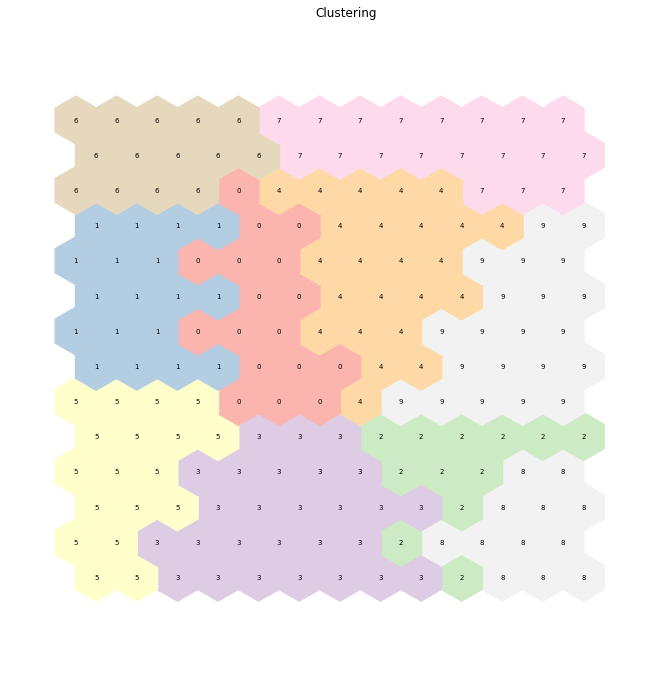

In [3]:
#Getting a first plot of our clusters
sbt.plot_clusters(nb_clusters=10, sm=som)

So we can see that the optimal size is 13 * 14. The topographic error is around 10%, so the dimension reduction respect pretty much the topography of the original dataset.

Some clusters are smallest than others but they seem to have approximatively the same size which is good thing. Nevertheless we can see that the cluster n°2 is graphically reaaly close to the n°8 and we can check with the initial data if they together represent a whole cluster or not.

Here, each cluster represents a type-profile of opinion on the 4 themes of the Grand Debat.

The **prototype visualization** shows the patterns learned by the neural network which are used to determine de winning neuron of each training instance.

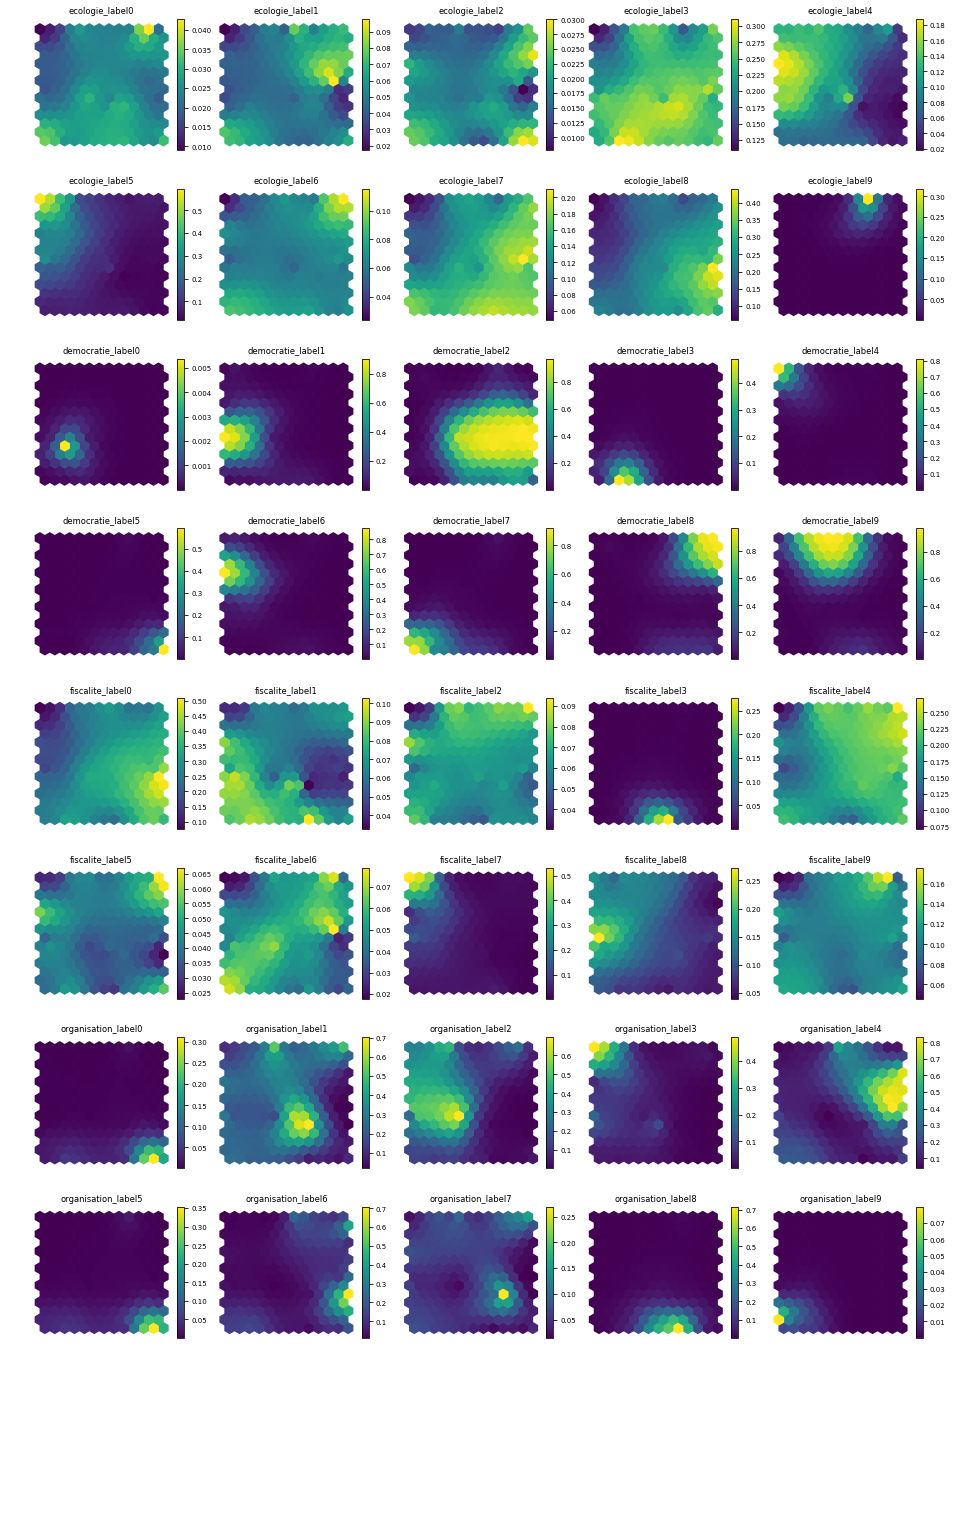

In [4]:
#Let's plot the prototype virtualization
sbt.prototype_visualization(sm=som)

The **Hit-map** shows how the instances are spreaded across the hexagonal lattice. The more instances lay into a cell, the more instances it is representing and hence the more we have to take it into acount

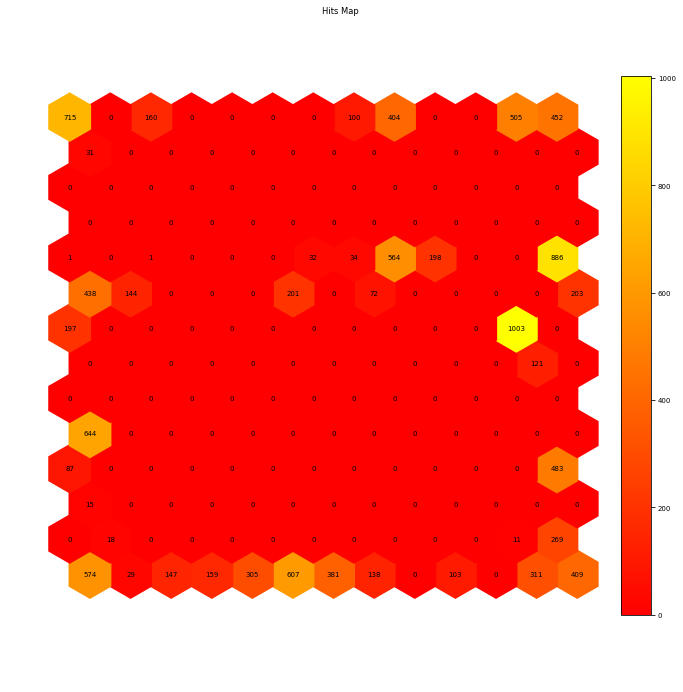

In [7]:
#Let's plot the hit map
sbt.hit_map(nb_models=10,sm=som)

Here the highest frequently choosen neuron is in cluster n°9: it seems like a lot of author-id are projected in this area. This region is really close to cluster n°2, it could mean that we should try to test the relevance an dthe proximity of these 2 clusters (should we merge it?)

Finally we can extract the 10 clusters into a list: each element of this list is a list which contains the author-id of a certain cluster

In [8]:
#Extract data
sbt.get_clusters(nb_clusters=10, X_projected=X, sm=som)

[['VXNlcjo0M2FkOGQ1ZS0yMjE3LTExZTktOTRkMi1mYTE2M2VlYjExZTE=',
  'VXNlcjo0M2Y3MjA2ZC0yM2RhLTExZTktOTRkMi1mYTE2M2VlYjExZTE=',
  'VXNlcjo0MDFkN2U2YS0yNTg4LTExZTktOTRkMi1mYTE2M2VlYjExZTE=',
  'VXNlcjo0MDY1NzQwNi0xZDZiLTExZTktOTRkMi1mYTE2M2VlYjExZTE=',
  'VXNlcjo0MDgwMDg2ZS0xZTQxLTExZTktOTRkMi1mYTE2M2VlYjExZTE=',
  'VXNlcjo0MGE5ZDNjZC0xZmYzLTExZTktOTRkMi1mYTE2M2VlYjExZTE=',
  'VXNlcjo0MGEzM2RlNS0xZDc3LTExZTktOTRkMi1mYTE2M2VlYjExZTE=',
  'VXNlcjo0MGI2MzA4ZC0yNjM4LTExZTktOTRkMi1mYTE2M2VlYjExZTE=',
  'VXNlcjo0MGIwNGFiNy0xZWVjLTExZTktOTRkMi1mYTE2M2VlYjExZTE=',
  'VXNlcjo0MGY5ZmNkOC0xZWY0LTExZTktOTRkMi1mYTE2M2VlYjExZTE=',
  'VXNlcjo0MTFmZDJhYS0xZTYxLTExZTktOTRkMi1mYTE2M2VlYjExZTE=',
  'VXNlcjo0MTJiNmNkYy0xZDg1LTExZTktOTRkMi1mYTE2M2VlYjExZTE=',
  'VXNlcjo0MTU4YTAzZi0xZmY0LTExZTktOTRkMi1mYTE2M2VlYjExZTE=',
  'VXNlcjo0MTZmODA0Ni0yMTkyLTExZTktOTRkMi1mYTE2M2VlYjExZTE=',
  'VXNlcjo0MThjY2YxZC0xOTZjLTExZTktOTRkMi1mYTE2M2VlYjExZTE=',
  'VXNlcjo0MWE3MWI1ZS0yM2VjLTExZTktOTRkMi1mYTE2M2VlYjExZTE=',
  'VXNlc

We haven't had time enough to check the relevance of our 10 typical profiles. If we had time, we would have read questions and answers on each clusters in order to make opinions profiles and test their relevance.

# Conclusion

Choosing a project based on unsupervised learning was not easy and as our group was very small, we haven't been able to fully complete our project.

In order to finish this project, we would have wanted to:

* **Check relevance on the first stage of learning (GMM) :** conducting tests on this training would be important since we have no clue if we learned well. But the fact that the input dataset is very heavy to compute (several hours) made the coding difficult and the time run.

* **Check relevance on our type profiles :** as we said previously, it would be necessary in order to check the relevance of our clusters to make opinion profiles by looking at many answers of people. But we are not sure if we have the skills to analyze such sociological facts.

* **Predict a non-answered theme questions :** extracting the answers of someone who answered 3/4 themes, then predicting on the first stage (GMM) and finally predicting its cluster with the SOM projection on the map.